In [49]:
import unicodedata
import re
import random
from datasets import load_dataset
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

# linea que arregla algunos errores de loadeo de datasets
# pip install --upgrade datasets

# Ejericio b)

### Imports

In [30]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertModel

# Descomentar en Windows
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# Descomentar en Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [31]:
device

device(type='mps')

### Definicion del DataLoader (importante)

In [32]:
from transformers import BertTokenizerFast  # FAST tokenizer recomendado

# Cargo tokenizar
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")

PUNCT_TAGS = {"Ø": 0, ",": 1, ".": 2, "?": 3, "¿": 4}
CAP_TAGS = {"lower": 0, "init": 1, "mix": 2, "upper": 3}

def _get_capitalization_type(word):
    if not word or word.islower(): return 0
    if word.istitle(): return 1
    if word.isupper(): return 3
    if any(c.isupper() for c in word[1:]): return 2
    return 0

def get_cap_labels_for_tokens(labels_per_word, token_word_map):
    """
    Recibe los labels por palabra y devuelve los labels por token para capitalizacion
    Si los subtokens pertenecen a la misma palabra, les pone el mismo label (capitalizacion) 
    """
    labels = []
    for word_idx in token_word_map:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(labels_per_word[word_idx])
    return labels

def get_punct_labels_for_tokens(labels_per_word, token_word_map):
    """
    Asigna etiquetas de puntuación a los subtokens, siguiendo las reglas:
    - ¿ va en el primer subtoken de la palabra.
    - ., ?, , van en el último subtoken de la palabra.
    - Ø no se asigna a ningún subtoken (todos -100).
    """
    labels = [0] * len(token_word_map)
    word_to_token_idxs = {}

    # Construimos un diccionario: word_idx -> [lista de posiciones de tokens]
    for token_idx, word_idx in enumerate(token_word_map):
        if word_idx is not None:
            word_to_token_idxs.setdefault(word_idx, []).append(token_idx)

    for word_idx, token_idxs in word_to_token_idxs.items():
        punct_label = labels_per_word[word_idx]
        if punct_label == PUNCT_TAGS["¿"]:
            target_idx = token_idxs[0]  # primer subtoken
        elif punct_label in {PUNCT_TAGS["."], PUNCT_TAGS[","], PUNCT_TAGS["?"]}:
            target_idx = token_idxs[-1]  # último subtoken
        else:
            continue  # Ø: no se asigna nada

        labels[target_idx] = punct_label

    return labels


def get_dataloader(oraciones_raw, max_length, batch_size, device):
    """
    Crea un DataLoader para entrenar un modelo de restauración de puntuación y capitalización.

    A partir de una lista de oraciones correctamente escritas (con puntuación y mayúsculas),
    esta función:
        - Extrae etiquetas de puntuación y capitalización por palabra.
        - "Corrompe" el texto al eliminar la puntuación y poner las palabras en minúscula.
        - Tokeniza las palabras corruptas usando un tokenizer BERT.
        - Alinea las etiquetas con los subtokens del tokenizer.
        - Crea tensores para las entradas (input_ids, attention_mask) y etiquetas (puntuación y capitalización).
        - Devuelve un DataLoader para entrenamiento en lotes.

    Parámetros:
        oraciones_raw (List[str]): Lista de oraciones correctamente formateadas.
        max_length (int): Longitud máxima de secuencia para truncar/padear.
        batch_size (int): Tamaño del batch.
        device (str): Dispositivo donde se cargarán los tensores ('cpu' o 'cuda').

    Retorna:
        DataLoader: DataLoader que entrega batches de (input_ids, attention_mask, punct_labels, cap_labels).
    """
    input_ids_list = []
    attention_masks = []
    punct_labels_list = []
    cap_labels_list = []

    for sent in oraciones_raw:
        # Extraer palabras con puntuación
        matches = list(re.finditer(r"\b\w+[^\s\w]?\b", sent)) # Detecta puntuaciones y las splitea
        words = []
        punct_labels = []
        cap_labels = []

        for i, m in enumerate(matches): # Recorre cada palabra detectada
            word_raw = m.group(0) 
            clean_word = re.sub(r"[.,?¿]", "", word_raw) # Limpia la palabra "Hola!" -> "Hola"

            # Puntuación
            before = sent[m.start() - 1] if m.start() > 0 else "" # Signo anterior
            after = sent[m.end()] if m.end() < len(sent) else ""  # Signo posterior
            if before == '¿':
                punct = PUNCT_TAGS["¿"]
            elif after in PUNCT_TAGS:
                punct = PUNCT_TAGS[after]
            else:
                punct = PUNCT_TAGS["Ø"]

            # Capitalización
            cap = _get_capitalization_type(word_raw)

            clean_word = clean_word.lower() # Limpia la palabra Hola -> hola

            words.append(clean_word)
            punct_labels.append(punct)
            cap_labels.append(cap)

        # Tokenización con BERT
        encoding = tokenizer(words,
                             is_split_into_words=True,
                             return_tensors='pt',
                             padding='max_length',
                             truncation=True,
                             max_length=max_length,
                             return_attention_mask=True)

        # Extraer datos que nos sirven del encoding
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        word_ids = encoding.word_ids(batch_index=0)  # Mapea cada subtoken a su palabra

        # Alinear etiquetas a subtokens (hasta ahora las teniamos en palabras)
        punct_labels_aligned = get_punct_labels_for_tokens(punct_labels, word_ids)
        cap_labels_aligned = get_cap_labels_for_tokens(cap_labels, word_ids)

        # Convertir a tensores
        punct_tensor = torch.tensor(punct_labels_aligned)
        cap_tensor = torch.tensor(cap_labels_aligned)

        # Aplicar -100 a posiciones de padding
        punct_tensor[attention_mask == 0] = -100
        cap_tensor[attention_mask == 0] = -100

        # Agregar a listas (por oracion)
        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        punct_labels_list.append(punct_tensor)
        cap_labels_list.append(cap_tensor)

    # Stackear tensores (por batch)
    input_ids = torch.stack(input_ids_list).to(device)
    attention_masks = torch.stack(attention_masks).to(device)
    punct_labels = torch.stack(punct_labels_list).to(device)
    cap_labels = torch.stack(cap_labels_list).to(device)

    dataset = TensorDataset(input_ids, attention_masks, punct_labels, cap_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


In [33]:
# Linea para entender como el get loader determina las puntuaciones

import re

# Ejemplo de oración
sentence = "¿que? Que raro, a mi me gusta mas tomar CocaCola"

# Encuentra palabras con posible puntuación al final
matches = list(re.finditer(r"\b\w+[^\s\w]?\b", sentence))

# Mostramos los resultados
for match in matches:
    word_raw = match.group(0)
    start = match.start()
    end = match.end()

    # Caracter anterior y posterior
    before = sentence[start - 1] if start > 0 else ""
    after = sentence[end] if end < len(sentence) else ""

    print(f"Palabra detectada : '{word_raw}'")
    print(f"Antes del match   : '{before}'")
    print(f"Después del match : '{after}'")
    print("---")


Palabra detectada : 'que'
Antes del match   : '¿'
Después del match : '?'
---
Palabra detectada : 'Que'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'raro'
Antes del match   : ' '
Después del match : ','
---
Palabra detectada : 'a'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'mi'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'me'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'gusta'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'mas'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'tomar'
Antes del match   : ' '
Después del match : ' '
---
Palabra detectada : 'CocaCola'
Antes del match   : ' '
Después del match : ''
---


### Dataset

In [34]:
# Armado del dataset

DATA_URLS = {
    "train": "https://huggingface.co/datasets/PlanTL-GOB-ES/SQAC/resolve/main/train.json",
    "dev":   "https://huggingface.co/datasets/PlanTL-GOB-ES/SQAC/resolve/main/dev.json",
    "test":  "https://huggingface.co/datasets/PlanTL-GOB-ES/SQAC/resolve/main/test.json",
}

raw = load_dataset(
    "json",
    data_files=DATA_URLS,
    field="data",
)

questions = []


for i in range(0, len(raw["train"])):
  for p in raw["train"][i]['paragraphs']:
    p_questions = [qas['question'] for qas in p['qas']]
    questions += p_questions

N_QUESTIONS = 5000  # Número de preguntas a procesar
questions = questions[:N_QUESTIONS]  # Limitar a N preguntas

print(f"Se descargaron {len(questions)} preguntas en Español.")


Se descargaron 5000 preguntas en Español.


In [35]:
dataset_rnn = load_dataset("google/wmt24pp", "en-es_MX", split="train")
oraciones_rnn = dataset_rnn['target'][1:]

print(f"Se descargaron {len(oraciones_rnn)} oraciones en Español (del dataset del notebook 10).")

Se descargaron 997 oraciones en Español (del dataset del notebook 10).


In [36]:
oraciones_sinteticas = []
import json
with open('./datasets/datasets.json', 'r') as file:
  data = json.load(file)

oraciones_sinteticas = data['otros'] + data['marcas']
print(f"Hay {len(oraciones_sinteticas)} oraciones sintéticas.")

Hay 1413 oraciones sintéticas.


In [37]:
import wikipedia
import json

# API Wikipedia
wikipedia.set_lang("es")


def obtener_frases_wikipedia(titulo, max_frases=100):
    try:
        pagina = wikipedia.page(titulo)
        texto = pagina.content
        oraciones = re.split(r'(?<=[.!?])\s+', texto)
        frases = [o.strip() for o in oraciones if 5 < len(o.split()) < 30]
        return frases[:max_frases]
    except Exception as e:
        print(f"Error al buscar '{titulo}': {e}")
        return []

# Ejemplo: obtener 50 frases de un artículo
frases = obtener_frases_wikipedia("Revolución francesa", max_frases=50)
for f in frases[:5]:
    print(f"- {f}")

temas = [
    # Países y lugares
    'Argentina', 'España', 'México', 'Colombia', 'Chile',
    'Perú', 'Uruguay', 'Brasil', 'América Latina', 'Europa',

    # Cultura argentina
    'Lionel Messi', 'Diego Maradona', 'Lali Esposito', 'Charly Garcia', 'Dillom',
    'Tiempos Violentos', 'Relatos Salvajes', 'Universidad de Buenos Aires', 'Rock nacional', 'Cine argentino',

    # Historia y política
    'Revolucion de Mayo', 'Independencia de Argentina', 'Simón Bolívar', 'Segunda Guerra Mundial', 'Guerra Fría',
    'Revolución Francesa', 'Guerra Civil Española', 'Napoleón Bonaparte', 'Nelson Mandela', 'Dictadura militar en Argentina',

    # Ciencia y tecnología
    'Inteligencia artificial', 'ChatGPT', 'Redes neuronales', 'Robótica', 'Energía solar',
    'Vacunas', 'COVID-19', 'Cambio climático', 'Computadora cuántica', 'NASA',

    # Cultura general
    'El Principito', 'Premio Nobel', 'Frida Kahlo', 'Pablo Picasso', 'Leonardo da Vinci',
    'William Shakespeare', 'Gabriel García Márquez', 'Julio Cortázar', 'Literatura latinoamericana', 'Arte contemporáneo',

    # Entretenimiento y medios
    'Marvel', 'DC Comics', 'Netflix', 'Cine de terror', 'Películas de ciencia ficción',
    'Música electrónica', 'Reguetón', 'Spotify', 'YouTube', 'TikTok',

    # Deportes
    'Fútbol', 'Copa Mundial de la FIFA', 'Juegos Olimpicos', 'Tenis', 'NBA',
    'Boca Juniors', 'River Plate', 'Messi vs Ronaldo', 'Fórmula 1', 'Michael Jordan',

    # Sociedad y actualidad
    'Feminismo', 'Día Internacional de la Mujer', 'Diversidad cultural', 'Migración', 'Pobreza',
    'Educación pública', 'Salud mental', 'Medio ambiente', 'Derechos humanos', 'Trabajo remoto',

    # Filosofía y pensamiento
    'Filosofía', 'Ética', 'Psicología', 'Sigmund Freud', 'Carl Jung',
    'Existencialismo', 'Sociología', 'Economía', 'Política', 'Democracia'
]

def cargar_json_wikipedia(archivo,temas, max_frases=100):
    """
    Carga un archivo JSON con frases de Wikipedia.
    """
    frases_wikipedia = []
    for tema in temas:
        print(f"Obteniendo frases de Wikipedia para: {tema}")
        frases = obtener_frases_wikipedia(tema,max_frases=100)
        print('Ejemplos de frases obtenidas:')
        for f in frases[:2]:
            print(f"- {f}")
        frases_wikipedia.extend(frases)
    # Guardar en un archivo JSON
    with open("datasets/frases_wikipedia.json", "w", encoding="utf-8") as f:
        json.dump(frases_wikipedia, f, ensure_ascii=False, indent=2)

    print("✅ Frases guardadas en 'datasets/frases_wikipedia.json'")
    

# Para actualizar la info de Wikipedia, descomentar la siguiente linea
# cargar_json_wikipedia("frases_wikipedia.json",temas, max_frases=100)

# Guardar en un archivo JSON
with open("datasets/frases_wikipedia.json", "r", encoding="utf-8") as f:
    frases_wikipedia = json.load(f)

print(frases_wikipedia[:5])  # muestra las primeras frases

len(frases_wikipedia)

- La corriente de pensamiento vigente en Francia era la Ilustración, cuyos principios se basaban en la razón, la igualdad y la libertad.
- La Ilustración había servido de impulso a las Trece Colonias norteamericanas para la independencia de su metrópolis europea.
- Tanto la influencia de la Ilustración como el ejemplo de los Estados Unidos sirvieron de «trampolín» ideológico para el inicio de la revolución en Francia.
- El otro gran lastre para la economía fue la deuda estatal.
- En 1788, la relación entre la deuda y la renta nacional bruta en Francia era del 55,6 %, en comparación con el 181,8 % en Gran Bretaña.
['Argentina, oficialmente República Argentina,[a]\u200b es un país soberano de América del Sur, ubicado en el extremo sur y sudeste de ese subcontinente.', 'Adopta la forma de gobierno republicana, democrática, representativa y federal.', 'Poseen Carta Magna, bandera y fuerzas de seguridad propias, el dominio de los recursos naturales circunscriptos en su territorio y delegan 

6648

In [38]:
def extraer_frases_dialogo(path_txt):
    personajes = [
    "Jorge", "Susana", "Mamá Cora", "Sergio", "Elvira", "Antonio", "Nora",
    "Matilde", "Dominga", "Felipe", "Emilia", "Doña Elisa", "Doña Gertrudis",
    "Don Genaro", "La Sorda", "Peralta", "Cacho", "Nene Florista"
    ]

    with open(path_txt, "r", encoding="utf-8") as f:
        raw = f.read()

    # Limpiar saltos múltiples y unificar espacios
    raw = re.sub(r"\n+", "\n", raw)

    # Construir patrón para encontrar encabezados de personaje
    nombres_pattern = "|".join(re.escape(p) for p in personajes)
    pattern = re.compile(rf"^({nombres_pattern})\s*[\.:–\-]+", re.MULTILINE)

    frases = []
    matches = list(pattern.finditer(raw))

    for i in range(len(matches)):
        start = matches[i].end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(raw)
        bloque = raw[start:end]

        # Limpiar texto: eliminar paréntesis, saltos de línea, espacios múltiples
        bloque = re.sub(r"\([^)]*\)", "", bloque)
        bloque = bloque.replace("\n", " ")
        bloque = re.sub(r"\s+", " ", bloque).strip()

        if bloque:
            frases.append(bloque)

    print(f"✅ Se extrajeron {len(frases)} frases completas y se guardaron en 'dialogos_esperando_la_carroza.json'")
    return frases

# Ejecutar la función y guardar a JSON
esperando_la_carroza = extraer_frases_dialogo("datasets/esperando_la_carroza.txt")

with open("datasets/dialogos_esperando_la_carroza.json", "w", encoding="utf-8") as f:
    json.dump(esperando_la_carroza, f, ensure_ascii=False, indent=2)

# Mostrar algunas frases aleatorias
print("✅ Frases extraídas y guardadas. Total:", len(esperando_la_carroza))
print(random.sample(esperando_la_carroza, 10))


✅ Se extrajeron 947 frases completas y se guardaron en 'dialogos_esperando_la_carroza.json'
✅ Frases extraídas y guardadas. Total: 947
['Por tu bien espero que lo seas, nena.', 'Ah...', 'Sí, mamá Cora.', '¿Te gusta? Lo compre en Mlami. Es precioso, ¿no?', '¿Edad?', 'Me pasé todo el invierno ahorrando peso a peso para comprarme un tapado, pero la vieja tuvo un ataque de hígado y todo lo que había juntado se me fue entre médicos y remedios, y a ninguno de ustedes se les ocurrió llamarnos para ver si necesitábamos ayuda.', 'Yo no hablé de capa negra.', '¿Sabés qué pasó? Susana había preparado una mayonesa bárbara y mamá en un descuido se la sacó y la transformó en flancitos.', 'Bueno, aunque no soy muy amiga de las masas. ¿No comés?', 'De que se equivocaron de muerta. Ese cadáver es de una intrusa. Hola!!! Hola!!!']


In [39]:
def extraer_frases_subtitulos(path_txt):
    with open(path_txt, "r", encoding="utf-8") as f:
        raw = f.read()

    bloques = re.split(r"\n\s*\n", raw)
    frases_crudas = []

    for bloque in bloques:
        lineas = bloque.strip().split("\n")
        if len(lineas) < 3:
            continue

        texto = " ".join(lineas[2:])
        texto = re.sub(r"^-", "", texto).strip()
        texto = re.sub(r"\s*-\s*", " ", texto)
        texto = re.sub(r"\s+", " ", texto).strip()

        # ❌ Filtrar frases vacías o solo puntos (como "..." o ". . .")
        if not texto or re.fullmatch(r"[. ]{2,}", texto):
            continue

        frases_crudas.append(texto)

    # 🔁 Unir frases incompletas (que no terminan en . ! ?)
    frases_limpias = []
    buffer = ""

    for frase in frases_crudas:
        if buffer:
            buffer += " " + frase
        else:
            buffer = frase

        if re.search(r"[.!?](['”\"])?$", buffer):
            frases_limpias.append(buffer.strip())
            buffer = ""

    if buffer:
        frases_limpias.append(buffer.strip())

    print(f"✅ Se extrajeron {len(frases_limpias)} frases de Relatos Salvajes.")
    return frases_limpias

# Ejemplo de uso
frases_relatos_salvajes = extraer_frases_subtitulos("datasets/subt_relatos_salvajes.srt")

# Guardar como JSON
with open("datasets/frases_relatos_salvajes.json", "w", encoding="utf-8") as f:
    json.dump(frases_relatos_salvajes, f, ensure_ascii=False, indent=2)

# Mostrar algunas frases
import random
print(random.sample(frases_relatos_salvajes, min(10, len(frases_relatos_salvajes))))

✅ Se extrajeron 1000 frases de Relatos Salvajes.
['Dale, chicas.', 'Pero, por favor. Por favor...', 'Sabe que sois un negro resentido.', 'Tuve la difícil tarea de comunicarle que repetía el año.', 'Por favor, decirle algo. No tiene la menor idea do que lo está haciendo.', 'Romina. ¿Si?', 'Nos arruinaste la vida todo, pelotudo.', 'Y quería saber cuanto tiempo tratarían de venir más o menos, porque...', 'Ya lo tienen decidido.', 'Servicio de acarreo son 490 pesos y la multa por la infracción la va a recibir en su domicilio.']


In [40]:
def limpiar_simbolos(frases):
    frases_limpias = []
    for frase in frases:
        # Eliminar cualquier secuencia de dos o más puntos (incluyendo con espacios): ... . .. etc.
        frase = re.sub(r"(\.\s*){2,}", "", frase)
        # Eliminar cualquier caracter que NO sea letra, número, espacio o los signos permitidos
        frase = re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ0-9¿?,. ]+", "", frase)
        # Reemplazar múltiples espacios por uno solo
        frase = re.sub(r"\s+", " ", frase).strip()
        frases_limpias.append(frase)
    return frases_limpias

# Eliminar signos de exclamación de las frases
frases_relatos_salvajes = limpiar_simbolos(frases_relatos_salvajes)
esperando_la_carroza = limpiar_simbolos(esperando_la_carroza)

oraciones_raw = questions + oraciones_rnn + oraciones_sinteticas + frases_wikipedia + esperando_la_carroza  + frases_relatos_salvajes

print('Cantidad total de oraciones:',len(oraciones_raw))
print('Cantidad de oraciones de preguntas:',len(questions))
print('Cantidad de oraciones en espa;ol de hugging face:',len(oraciones_rnn))
print('Cantidad de oraciones sintéticas:',len(oraciones_sinteticas))
print('Cantidad de oraciones de Wikipedia:',len(frases_wikipedia))
print('Cantidad de oraciones de Esperando la carroza:',len(esperando_la_carroza))
print('Cantidad de oraciones de Relatos Salvajes:',len(frases_relatos_salvajes))

# Muestra algunas oraciones aleatorias
print("Algunas oraciones aleatorias:")
random.sample(oraciones_raw, 30)

Cantidad total de oraciones: 16005
Cantidad de oraciones de preguntas: 5000
Cantidad de oraciones en espa;ol de hugging face: 997
Cantidad de oraciones sintéticas: 1413
Cantidad de oraciones de Wikipedia: 6648
Cantidad de oraciones de Esperando la carroza: 947
Cantidad de oraciones de Relatos Salvajes: 1000
Algunas oraciones aleatorias:


['Pepsi a menudo se compara con Coca-Cola.',
 'Te viniste con todos los cables pelados, eh',
 'De esta manera partieron, por ejemplo, los primeros disidentes religiosos de Europa hacia Norteamérica.',
 'Mi amigo de la universidad, Javier, trabaja en una consultora de la ONU.',
 'Este código influyó de manera trascendental en el mundo jurídico, y fue la piedra angular del proceso de codificación.',
 'Facebook tiene miles de millones de usuarios.',
 '¿Cuántos tipos de mormyroidea existen?',
 'No, señor. Salí de acá. Esto se descarga en mi casa.',
 'Mi mujer quería hacerlo como punto de partida. Sin entrar demasiado en sus asuntos, ella tiene motivos para dudar de que algunos de sus antepasados sean realmente sus antepasados. En mi caso, es para apoyarla y ver el efecto de la deriva genética en una muestra de tamaño minúsculo; tenemos registros familiares bastante extensos.',
 'Lo que te estoy proponiendo me avergüenza.',
 'su significado se refiere a toda la tierra al oeste del mar Egeo.

In [41]:
from sklearn.model_selection import train_test_split

train_sents, test_sents = train_test_split(oraciones_raw, test_size=0.05, random_state=42)

dataloader_train = get_dataloader(oraciones_raw=oraciones_raw, max_length=64, batch_size=64, device=device)
dataloader_test = get_dataloader(oraciones_raw=test_sents, max_length=64, batch_size=64, device=device)

print(len(train_sents))
print(len(test_sents))

15204
801


### RNN

In [42]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


class PunctuationCapitalizationRNN(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_punct_classes, num_cap_classes, dropout=0.3):
        super().__init__()
        self.bert = bert_model                        # ahora el modelo completo
        self.projection = nn.Linear(
            self.bert.config.hidden_size, hidden_dim
        )
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=2,
                           batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout)
        self.punct_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_punct_classes)
        )
        self.cap_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_cap_classes)
        )

    def forward(self, input_ids, attention_mask=None):
        # BERT retorna last_hidden_state: (B, T, H_bert)
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        projected = self.projection(hidden_states)   # (B, T, hidden_dim)

        # mismo packing/padding de antes
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1)
            packed = pack_padded_sequence(projected, lengths.cpu(),
                                          batch_first=True, enforce_sorted=False)
            rnn_out_packed, _ = self.rnn(packed)
            rnn_out, _ = pad_packed_sequence(
                rnn_out_packed, batch_first=True, total_length=projected.size(1)
            )
        else:
            rnn_out, _ = self.rnn(projected)

        rnn_out = self.dropout(rnn_out)
        punct_logits = self.punct_classifier(rnn_out)
        cap_logits   = self.cap_classifier(rnn_out)
        return punct_logits, cap_logits

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

# Funcion de entrenamiento
def train(model, dataloader_train, dataloader_test, optimizer, criterion_punct, criterion_cap, device, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for input_ids, attention_mask, punct_labels, cap_labels in dataloader_train:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            punct_labels = punct_labels.to(device)
            cap_labels = cap_labels.to(device)

            optimizer.zero_grad()

            punct_logits, cap_logits = model(input_ids, attention_mask)

            loss_punct = criterion_punct(punct_logits.view(-1, punct_logits.shape[-1]), punct_labels.view(-1))
            loss_cap = criterion_cap(cap_logits.view(-1, cap_logits.shape[-1]), cap_labels.view(-1))

            loss = loss_punct + loss_cap
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader_train)

        """
        # Evaluación en test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for input_ids, attention_mask, punct_labels, cap_labels in dataloader_test:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                punct_labels = punct_labels.to(device)
                cap_labels = cap_labels.to(device)

                punct_logits, cap_logits = model(input_ids, attention_mask)

                loss_punct = criterion(punct_logits.view(-1, punct_logits.shape[-1]), punct_labels.view(-1))
                loss_cap = criterion(cap_logits.view(-1, cap_logits.shape[-1]), cap_labels.view(-1))

                loss = loss_punct + loss_cap
                test_loss += loss.item()

        avg_test_loss = test_loss / len(dataloader_test)
        """

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")



def evaluate(model, dataloader, device):
    model.eval()

    inv_punct = {v: k for k, v in PUNCT_TAGS.items()}
    inv_cap = {v: k for k, v in CAP_TAGS.items()}

    all_true_punct = []
    all_pred_punct = []
    all_true_cap = []
    all_pred_cap = []

    with torch.no_grad():
        for input_ids, attention_mask, punct_labels, cap_labels in dataloader:
            input_ids = input_ids.to(device)
            punct_labels = punct_labels.to(device)
            cap_labels = cap_labels.to(device)

            punct_logits, cap_logits = model(input_ids)

            pred_punct = torch.argmax(punct_logits, dim=-1)
            pred_cap = torch.argmax(cap_logits, dim=-1)

            # Máscara para ignorar tokens sin etiqueta
            mask = (punct_labels != -100)

            # Aplicar máscara y aplanar para comparación
            all_true_punct.extend(punct_labels[mask].cpu().numpy())
            all_pred_punct.extend(pred_punct[mask].cpu().numpy())

            all_true_cap.extend(cap_labels[mask].cpu().numpy())
            all_pred_cap.extend(pred_cap[mask].cpu().numpy())

    # Añadir todas las posibles etiquetas para evitar que falten en el reporte
    all_punct_labels = list(PUNCT_TAGS.values())
    all_cap_labels = list(CAP_TAGS.values())

    print("Unique classes in true labels:", set(all_true_cap))
    print("Unique classes in predictions:", set(all_pred_cap))

    print("🔍 Unique true cap labels:", set(all_true_cap))
    print("🔍 Unique pred cap labels:", set(all_pred_cap))
    print("🔍 Unique true punct labels:", set(all_true_punct))
    print("🔍 Unique pred punct labels:", set(all_pred_punct))

    # Accuracy generales
    punct_acc = np.mean(np.array(all_true_punct) == np.array(all_pred_punct))
    cap_acc = np.mean(np.array(all_true_cap) == np.array(all_pred_cap))

    print("📌 Punctuation Accuracy:     {:.4f}".format(punct_acc))
    print("🔡 Capitalization Accuracy: {:.4f}".format(cap_acc))

    # Reporte de clasificación detallado (asegurar que todas las clases estén presentes)
    print("\n📊 Punctuation classification report:")
    print(classification_report(
        all_true_punct, 
        all_pred_punct, 
        labels=all_punct_labels,  # Aseguramos que todas las clases estén
        target_names=[k for k in PUNCT_TAGS.keys()]  # Usamos las claves como nombres
    ))

    print("\n📊 Capitalization classification report:")
    print(classification_report(
        all_true_cap, 
        all_pred_cap, 
        labels=all_cap_labels,  # Aseguramos que todas las clases estén
        target_names=[k for k in CAP_TAGS.keys()]  # Usamos las claves como nombres
    ))

    # Generar y visualizar la matriz de confusión de puntuación
    print("\n📊 Punctuation confusion matrix:")
    cm_punct = confusion_matrix(all_true_punct, all_pred_punct, labels=all_punct_labels)

    # Visualización de la matriz de confusión para puntuación
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_punct, annot=True, fmt="d", cmap="Blues", xticklabels=PUNCT_TAGS.keys(), yticklabels=PUNCT_TAGS.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Punctuation Confusion Matrix')
    plt.show()

    # Generar y visualizar la matriz de confusión de capitalización
    print("\n📊 Capitalization confusion matrix:")
    cm_cap = confusion_matrix(all_true_cap, all_pred_cap, labels=all_cap_labels)

    # Visualización de la matriz de confusión para capitalización
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_cap, annot=True, fmt="d", cmap="Blues", xticklabels=CAP_TAGS.keys(), yticklabels=CAP_TAGS.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Capitalization Confusion Matrix')
    plt.show()

    return punct_acc, cap_acc

In [ ]:
# Embeddings de BERT

model_name = "bert-base-multilingual-cased"
bert_model = BertModel.from_pretrained(model_name)

bert_embeddings = bert_model.embeddings.word_embeddings
for param in bert_embeddings.parameters():
    param.requires_grad = False


# Congelar la mayoría de los parámetros de BERT salvo los últimos N layers y el pooler
N = 2
for layer in bert_model.encoder.layer[-N:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in bert_model.pooler.parameters():
    param.requires_grad = True


# Crear el modelo
model = PunctuationCapitalizationRNN(
    bert_model = bert_model,
    hidden_dim=256,
    num_punct_classes=len(PUNCT_TAGS),
    num_cap_classes=len(CAP_TAGS)
).to(device)


# le quiero pasar el weight param al criterion para mejorar el desbalanceo de clases en base a un counter de tokens
# Contar ocurrencias de cada etiqueta de puntuación y capitalización
punct_counter = Counter()
cap_counter = Counter()
for input_ids, attention_mask, punct_labels, cap_labels in dataloader_train:
    # Convertir a CPU y a numpy para contar
    punct_labels_np = punct_labels.cpu().numpy()
    cap_labels_np = cap_labels.cpu().numpy()

    # Contar etiquetas válidas (ignorando -100)
    valid_punct = punct_labels_np[punct_labels_np != -100]
    valid_cap = cap_labels_np[cap_labels_np != -100]

    punct_counter.update(valid_punct)
    cap_counter.update(valid_cap)

# como las clases estan desbalanceadas, calculamos los pesos inversos
total_punct = sum(punct_counter.values())
total_cap = sum(cap_counter.values())
beta = 0.7

total_punct = sum(punct_counter.values())
total_cap   = sum(cap_counter.values())

punct_weights = {
    tag: (total_punct / count)**beta
    for tag, count in punct_counter.items()
}
cap_weights = {
    tag: (total_cap / count)**beta
    for tag, count in cap_counter.items()
}

# pasar a tensor (clamp opcional para evitar extremos)
punct_weights_tensor = torch.tensor(
    [punct_weights.get(i, 1.0) for i in range(len(PUNCT_TAGS))],
    dtype=torch.float32
).to(device).clamp(min=1.0, max=5.0)

cap_weights_tensor = torch.tensor(
    [cap_weights.get(i, 1.0) for i in range(len(CAP_TAGS))],
    dtype=torch.float32
).to(device).clamp(min=1.0, max=5.0)


criterion_punct = nn.CrossEntropyLoss(ignore_index=-100, weight=punct_weights_tensor)
criterion_cap   = nn.CrossEntropyLoss(ignore_index=-100, weight=cap_weights_tensor)
trainable_params = [
    p for p in bert_model.parameters() if p.requires_grad
] + list(model.projection.parameters()) \
  + list(model.rnn.parameters()) \
  + list(model.punct_classifier.parameters()) \
  + list(model.cap_classifier.parameters())

optimizer = torch.optim.AdamW(trainable_params, lr=2e-5)
# Entrenamiento 
train(model, dataloader_train=dataloader_train, dataloader_test=dataloader_test,optimizer=optimizer, criterion_punct=criterion_punct, criterion_cap = criterion_cap, device=device, epochs=20)

Epoch 1 | Train Loss: 2.0249


Unique classes in true labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-100)}
Unique classes in predictions: {np.int64(0), np.int64(1), np.int64(2)}
🔍 Unique true cap labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-100)}
🔍 Unique pred cap labels: {np.int64(0), np.int64(1), np.int64(2)}
🔍 Unique true punct labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
🔍 Unique pred punct labels: {np.int64(0), np.int64(3)}
📌 Punctuation Accuracy:     0.9061
🔡 Capitalization Accuracy: 0.7953

📊 Punctuation classification report:
              precision    recall  f1-score   support

           Ø       0.91      1.00      0.95     15399
           ,       0.00      0.00      0.00       470
           .       0.00      0.00      0.00       557
           ?       0.00      0.00      0.00       281
           ¿       0.00      0.00      0.00       285

    accuracy                           0.91     16992
   macro avg       0.18      0.2

/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

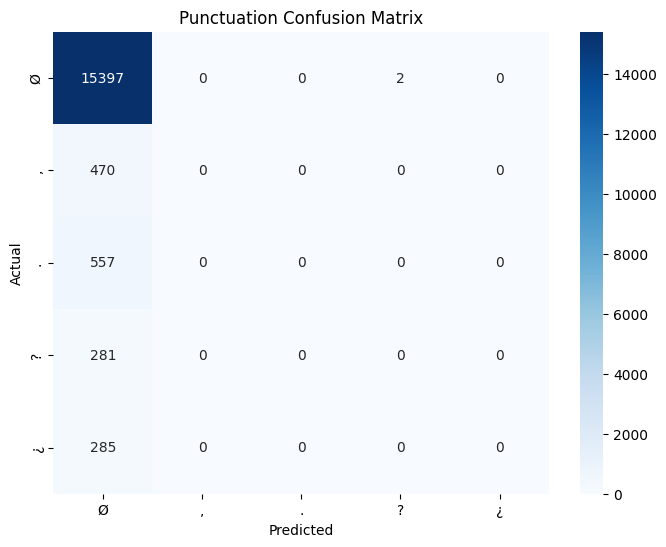


📊 Capitalization confusion matrix:


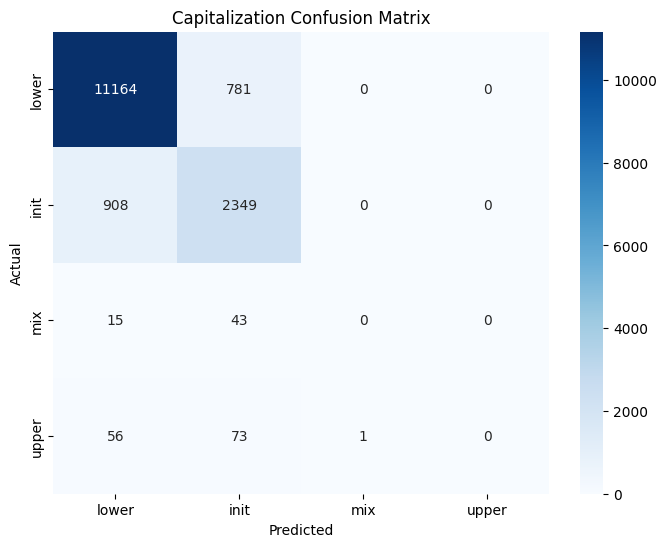

(np.float64(0.906132297551789), np.float64(0.7952565913370998))

In [56]:
evaluate(model, dataloader_test, device)

In [20]:
def predict_and_reconstruct(model, sentence, tokenizer, device, max_length=64, verbose=True):
    model.eval()

    encoding = tokenizer(
        sentence,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_attention_mask=True,
        return_token_type_ids=False
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        punct_logits, cap_logits = model(input_ids, attention_mask=attention_mask)

    pred_punct = torch.argmax(punct_logits, dim=-1)[0].cpu().tolist()
    pred_cap = torch.argmax(cap_logits, dim=-1)[0].cpu().tolist()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    INV_PUNCT_TAGS = {v: k for k, v in PUNCT_TAGS.items()}

    final_words = []
    current_word = ""
    current_cap = 0
    current_punct = 0
    new_word = True

    if verbose == True:
        print("\n🔍 Predicción token por token:")
        print(f"{'TOKEN':15s} | {'PUNCT':>5s} | {'SIGNO':>5s} | {'CAP':>3s} | {'FINAL':15s}")
        print("-" * 55)

    for i, (token, punct_label, cap_label) in enumerate(zip(tokens, pred_punct, pred_cap)):
        if token in ["[CLS]", "[SEP]", "[PAD]"] or attention_mask[0, i].item() == 0:
            continue

        clean_token = token.replace("##", "")

        if token.startswith("##"):
            current_word += clean_token
            if punct_label != 0:
                current_punct = punct_label  # usar puntuación del último subtoken relevante
        else:
            if current_word:
                # cerrar palabra anterior
                word = current_word
                # aplicar capitalización a toda la palabra
                if current_cap == 1:
                    word = word.capitalize()
                elif current_cap == 2:
                    word = ''.join(c.upper() if random.random() > 0.5 else c.lower() for c in word)
                elif current_cap == 3:
                    word = word.upper()
                # aplicar puntuación del último subtoken
                punct = INV_PUNCT_TAGS.get(current_punct, "Ø")
                if punct == "¿":
                    word = "¿" + word
                elif punct != "Ø":
                    word = word + punct
                final_words.append(word)

            # empezar nueva palabra
            current_word = clean_token
            current_cap = cap_label
            current_punct = punct_label if punct_label != 0 else 0

        if verbose:
            print(f"{clean_token:15s} | {punct_label:5d} | {INV_PUNCT_TAGS.get(punct_label, 'Ø'):>5s} | {cap_label:3d} | {clean_token:15s}")

    # Procesar última palabra
    if current_word:
        word = current_word
        if current_cap == 1:
            word = word.capitalize()
        elif current_cap == 2:
            word = ''.join(c.upper() if random.random() > 0.5 else c.lower() for c in word)
        elif current_cap == 3:
            word = word.upper()
        punct = INV_PUNCT_TAGS.get(current_punct, "Ø")
        if punct == "¿":
            word = "¿" + word
        elif punct != "Ø":
            word = word + punct
        final_words.append(word)

    return " ".join(final_words)


In [94]:
entrada = "hola como estas"
print(f"{entrada} => {predict_and_reconstruct(model, entrada, tokenizer, device, verbose=False)}")


hola como estas => HOLA. COMO. ESTAS.


#### Prueba con overfitting

In [27]:
frases = ["Buenas tardes, quiero un AppLe Por Favor. Muchisimas gracias"]

train_loader = get_dataloader(frases, max_length=25, batch_size=1, device=device)

model = PunctuationCapitalizationRNN(
    bert_model=bert_model,
    hidden_dim=64,
    num_punct_classes=5,
    num_cap_classes=4
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Alto LR
criterion_punct = nn.CrossEntropyLoss(ignore_index=-100)
criterion_cap = nn.CrossEntropyLoss(ignore_index=-100)

train(model, train_loader, train_loader,optimizer, criterion_punct, criterion_cap, device, epochs=300)

entrada = "buenas tardes quiero un apple por favor muchisimas gracias"
print("Predicción:", predict_and_reconstruct(model, entrada, tokenizer, device))


Epoch 1 | Train Loss: 3.0747
Epoch 2 | Train Loss: 2.9317
Epoch 3 | Train Loss: 2.4662
Epoch 4 | Train Loss: 1.8919
Epoch 5 | Train Loss: 1.5482
Epoch 6 | Train Loss: 1.5781
Epoch 7 | Train Loss: 1.6214
Epoch 8 | Train Loss: 1.7006
Epoch 9 | Train Loss: 1.8374
Epoch 10 | Train Loss: 1.4302
Epoch 11 | Train Loss: 1.4104
Epoch 12 | Train Loss: 1.5572
Epoch 13 | Train Loss: 1.4700
Epoch 14 | Train Loss: 1.5857
Epoch 15 | Train Loss: 1.5490
Epoch 16 | Train Loss: 1.6039
Epoch 17 | Train Loss: 1.5179
Epoch 18 | Train Loss: 1.4521
Epoch 19 | Train Loss: 1.5576
Epoch 20 | Train Loss: 1.5094
Epoch 21 | Train Loss: 1.6196
Epoch 22 | Train Loss: 1.4636
Epoch 23 | Train Loss: 1.5424
Epoch 24 | Train Loss: 1.8560
Epoch 25 | Train Loss: 1.4670
Epoch 26 | Train Loss: 1.5929
Epoch 27 | Train Loss: 1.5640
Epoch 28 | Train Loss: 1.7464
Epoch 29 | Train Loss: 1.5229
Epoch 30 | Train Loss: 1.6446
Epoch 31 | Train Loss: 1.6972
Epoch 32 | Train Loss: 1.6183
Epoch 33 | Train Loss: 1.6643
Epoch 34 | Train Lo

In [28]:
# Prueba del model.eval

lista_frases = [
    "Hola, ¿cómo estás?",
    "¿Qué tal? Espero que bien.",
    "¡Hola! ¿Cómo va todo?",
    "Buenos días, ¿cómo amaneciste?",
    "Buenas tardes, ¿qué planes tienes hoy?",
    "Buenas noches, espero que hayas tenido un buen día.",
    "Hola, ¿qué tal tu día?",
    "¿Cómo te encuentras hoy?",
    "¡Hola! ¿Cómo te sientes?",
    "¿Qué tal va tu semana?"
]

dataloader = get_dataloader(lista_frases, max_length=25, batch_size=1, device=device)
evaluate(model, dataloader, device)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Unique classes in true labels: {np.int64(0), np.int64(1), np.int64(-100)}
Unique classes in predictions: {np.int64(0), np.int64(1), np.int64(2)}
🔍 Unique true cap labels: {np.int64(0), np.int64(1), np.int64(-100)}
🔍 Unique pred cap labels: {np.int64(0), np.int64(1), np.int64(2)}
🔍 Unique true punct labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
🔍 Unique pred punct labels: {np.int64(0), np.int64(1), np.int64(2)}
📌 Punctuation Accuracy:     0.6941
🔡 Capitalization Accuracy: 0.5529

📊 Punctuation classification report:
              precision    recall  f1-score   support

           Ø       0.76      0.93      0.84        60
           ,       0.30      0.60      0.40         5
           .       0.00      0.00      0.00         2
           ?       0.00      0.00      0.00         9
           ¿       0.00      0.00      0.00         9

    accuracy                           0.69        85
   macro avg       0.21      0.31      0.25        85
weighted avg     

/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/malenaalamo/Personal/AA2/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

(np.float64(0.6941176470588235), np.float64(0.5529411764705883))

### RNN Bidireccional

In [63]:
class PunctuationCapitalizationRNNBidireccional(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_punct_classes, num_cap_classes, dropout=0.3):
        super().__init__()
        self.bert = bert_model  # Modelo BERT preentrenado
        self.projection = nn.Linear(self.bert.config.hidden_size, hidden_dim)
        
        # LSTM Bidireccional
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=2,
                           batch_first=True, bidirectional=True)  # Cambiado a bidireccional
        self.dropout = nn.Dropout(dropout)
        
        # Capa para clasificación de puntuación
        self.punct_classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),  # Salida bidireccional, por lo tanto 2 * hidden_dim
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_punct_classes)
        )
        
        # Capa para clasificación de capitalización
        self.cap_classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),  # Salida bidireccional, por lo tanto 2 * hidden_dim
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_cap_classes)
        )

    def forward(self, input_ids, attention_mask=None):
        # Pasar los inputs por BERT
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (B, T, H_bert)

        # Proyectar la salida de BERT al tamaño de hidden_dim
        projected = self.projection(hidden_states)   # (B, T, hidden_dim)

        # Empacar la secuencia para LSTM
        if attention_mask is not None:
            lengths = attention_mask.sum(dim=1)
            packed = pack_padded_sequence(projected, lengths.cpu(),
                                          batch_first=True, enforce_sorted=False)
            rnn_out_packed, _ = self.rnn(packed)
            rnn_out, _ = pad_packed_sequence(
                rnn_out_packed, batch_first=True, total_length=projected.size(1)
            )
        else:
            rnn_out, _ = self.rnn(projected)

        # Aplicar dropout
        rnn_out = self.dropout(rnn_out)
        
        # Clasificación para puntuación y capitalización
        punct_logits = self.punct_classifier(rnn_out)
        cap_logits = self.cap_classifier(rnn_out)
        
        return punct_logits, cap_logits

In [65]:
# Embeddings de BERT

model_name = "bert-base-multilingual-cased"
bert_model = BertModel.from_pretrained(model_name)

bert_embeddings = bert_model.embeddings.word_embeddings
for param in bert_embeddings.parameters():
    param.requires_grad = False


# Congelar la mayoría de los parámetros de BERT salvo los últimos N layers y el pooler
N = 2
for layer in bert_model.encoder.layer[-N:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in bert_model.pooler.parameters():
    param.requires_grad = True


# Crear el modelo
model = PunctuationCapitalizationRNNBidireccional(
    bert_model = bert_model,
    hidden_dim=256,
    num_punct_classes=len(PUNCT_TAGS),
    num_cap_classes=len(CAP_TAGS)
).to(device)


# le quiero pasar el weight param al criterion para mejorar el desbalanceo de clases en base a un counter de tokens
# Contar ocurrencias de cada etiqueta de puntuación y capitalización
punct_counter = Counter()
cap_counter = Counter()
for input_ids, attention_mask, punct_labels, cap_labels in dataloader_train:
    # Convertir a CPU y a numpy para contar
    punct_labels_np = punct_labels.cpu().numpy()
    cap_labels_np = cap_labels.cpu().numpy()

    # Contar etiquetas válidas (ignorando -100)
    valid_punct = punct_labels_np[punct_labels_np != -100]
    valid_cap = cap_labels_np[cap_labels_np != -100]

    punct_counter.update(valid_punct)
    cap_counter.update(valid_cap)

# como las clases estan desbalanceadas, calculamos los pesos inversos
total_punct = sum(punct_counter.values())
total_cap = sum(cap_counter.values())
beta = 0.7

total_punct = sum(punct_counter.values())
total_cap   = sum(cap_counter.values())

punct_weights = {
    tag: (total_punct / count)**beta
    for tag, count in punct_counter.items()
}
cap_weights = {
    tag: (total_cap / count)**beta
    for tag, count in cap_counter.items()
}

# pasar a tensor (clamp opcional para evitar extremos)
punct_weights_tensor = torch.tensor(
    [punct_weights.get(i, 1.0) for i in range(len(PUNCT_TAGS))],
    dtype=torch.float32
).to(device).clamp(min=1.0, max=5.0)

cap_weights_tensor = torch.tensor(
    [cap_weights.get(i, 1.0) for i in range(len(CAP_TAGS))],
    dtype=torch.float32
).to(device).clamp(min=1.0, max=5.0)


criterion_punct = nn.CrossEntropyLoss(ignore_index=-100, weight=punct_weights_tensor)
criterion_cap   = nn.CrossEntropyLoss(ignore_index=-100, weight=cap_weights_tensor)
trainable_params = [
    p for p in bert_model.parameters() if p.requires_grad
] + list(model.projection.parameters()) \
  + list(model.rnn.parameters()) \
  + list(model.punct_classifier.parameters()) \
  + list(model.cap_classifier.parameters())

optimizer = torch.optim.AdamW(trainable_params, lr=2e-5)
# Entrenamiento 
train(model, dataloader_train=dataloader_train, dataloader_test=dataloader_test,optimizer=optimizer, criterion_punct=criterion_punct, criterion_cap = criterion_cap, device=device, epochs=15)

KeyboardInterrupt: 

Unique classes in true labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-100)}
Unique classes in predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
🔍 Unique true cap labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-100)}
🔍 Unique pred cap labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3)}
🔍 Unique true punct labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
🔍 Unique pred punct labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
📌 Punctuation Accuracy:     0.9220
🔡 Capitalization Accuracy: 0.8748

📊 Punctuation classification report:
              precision    recall  f1-score   support

           Ø       0.99      0.95      0.97     15399
           ,       0.31      0.76      0.44       470
           .       0.58      0.74      0.65       557
           ?       1.00      0.00      0.01       281
           ¿       0.66      0.92      0.77       285

    accuracy         

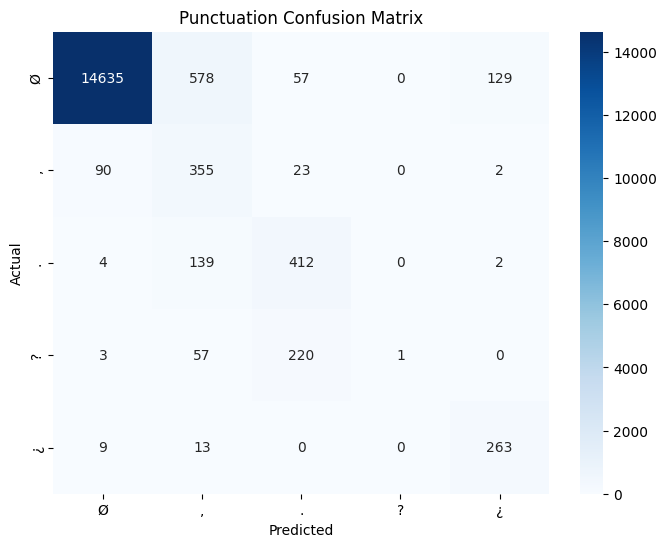


📊 Capitalization confusion matrix:


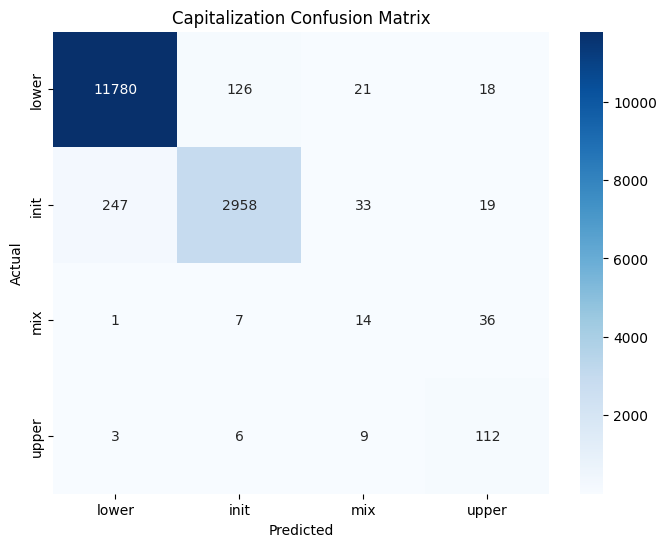

(np.float64(0.9219632768361582), np.float64(0.8747645951035782))

In [59]:
evaluate(model, dataloader_test, device)

In [66]:
# hola amigo fabro

In [62]:
entrada = "queres ver mi nuevo disco"
print(f"{entrada} => {predict_and_reconstruct(model, entrada, tokenizer, device, verbose=False)}")

queres ver mi nuevo disco => ¿Queres ver mi nuevo disco?


### Export modelo

In [147]:
torch.save(model, "modelo_fine_tuned.pt")

In [148]:
torch.save(model.state_dict(), "modelo_fine_tuned_state_dict.pt")

In [153]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 179,236,873
Trainable parameters: 87,424,777
